## Image retrieval based on sketch and text

## Model 

### Path set up and import

In [1]:
%cd ../../tsbir/notebooks

/home/aikusrv02/hyemin/tsbir/notebooks


In [2]:
from pathlib import Path
CODE_PATH = Path('../code/')
MODEL_PATH = Path('../model/')
DATA_PATH = Path('../../dataset/')
IMAGE_PATH = Path('../../dataset/images/')
SKETCH_PATH = Path('../sketches/')


In [24]:
# !wget -N https://patsorn.me/projects/tsbir/data/tsbir_model_final.pt -P {MODEL_PATH}

In [3]:
import os
import numpy as np
import json
import torch
import sys
sys.path.append('../code/')

##make sure CODE_PATH is pointing to the correct path containing clip.py before running 
from clip.model import convert_weights, CLIP


In [4]:
model_config_file = CODE_PATH / 'training/model_configs/ViT-B-16.json'
model_file = MODEL_PATH / 'tsbir_model_final.pt'

In [5]:
import torch
import json

gpus = [0, 1, 2, 3, 4]
torch.cuda.set_device(gpus[0])  # 메인 GPU를 지정합니다.

with open(model_config_file, 'r') as f:
    model_info = json.load(f)
        
model = CLIP(**model_info)

loc = "cuda:{}".format(gpus[0])
checkpoint = torch.load(model_file, map_location=loc)

sd = checkpoint["state_dict"] 
if next(iter(sd.items()))[0].startswith('module'):
    sd = {k[len('module.'):]: v for k, v in sd.items()}

model.load_state_dict(sd, strict=False)

model.train()

model = torch.nn.DataParallel(model, device_ids=gpus)

model = model.cuda()



Is not instance - Visual Transformer


# Train

### Data Loader

In [6]:
import json
import random
import os

from clip.clip import _transform, load

convert_weights(model)
preprocess_train = _transform(model.module.visual.input_resolution, is_train=True)
preprocess_val = _transform(model.module.visual.input_resolution, is_train=False)
preprocess_fn = (preprocess_train, preprocess_val)

from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.utils.data.distributed import DistributedSampler
from dataclasses import dataclass

@dataclass
class DataInfo:
    dataloader: DataLoader
    sampler: DistributedSampler

# path = '../../dataset/'

class TripletDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform
        
        self.data_list = []
        
        for data_name in ["ghoumrassi", "karol-skorulski"]:
            base = os.path.join(self.path, data_name)
            img = os.path.join(base, data_name+'_image')
            sketch = os.path.join(base, data_name+'_edge_new')
            txt = os.path.join(base, data_name+'_text')
            
            # splitext: 확장자 분리 (001.jpg -> ['001', '.jpg'])
            img_paths = sorted([os.path.join(img, v) for v in os.listdir(img)], key=lambda x: int(os.path.splitext(x.split('_')[-1])[0]))
            sketch_paths = sorted([os.path.join(sketch, v) for v in os.listdir(sketch)], key=lambda x: int(os.path.splitext(x.split('_')[-1])[0]))
            txt_paths = sorted([os.path.join(txt, v) for v in os.listdir(txt)], key=lambda x: int(os.path.splitext(x.split('_')[-1])[0]))
            
            
            for img_path, sketch_path, txt_path in zip(img_paths, sketch_paths, txt_paths):
                self.data_list.append({
                    'image_path': img_path,
                    'sketch_path': sketch_path,
                    'text_path': txt_path
                })
        
        
    def get_text(self, json_path):
        with open(json_path, 'r') as json_file:
            data = json.load(json_file)
            return data['text']

    def set_transform(self, transform):
        self.transform = transform
    
    def __getitem__(self, index):
        data = self.data_list[index]
        image_path, sketch_path, text_path = data['image_path'], data['sketch_path'], data['text_path']
        image = Image.open(image_path)
        sketch = Image.open(sketch_path)
        text = self.get_text(text_path)
        
        if self.transform is not None:
            
            image = self.transform(image)
            sketch = self.transform(sketch)
            
        return image, sketch, text
       

    def __len__(self):
        return len(self.data_list)

In [31]:
import torch
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Subset
from PIL import Image

torch.manual_seed(42)


def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)

dataset = TripletDataset(DATA_PATH, transform=preprocess_val)  # train or val

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 1 - (train_ratio + val_ratio)

train_size = int(train_ratio * len(dataset))
val_size = int(val_ratio * len(dataset))
test_size = len(dataset) - (train_size + val_size)

train_dataset, temp_dataset = random_split(dataset, [train_size, val_size + test_size])
val_indices, test_indices = random_split(range(len(temp_dataset)), [val_size, test_size])

# Extract the subset dataset according to the index
val_dataset = Subset(TripletDataset(DATA_PATH, transform=preprocess_val), val_indices.indices)
test_dataset = Subset(TripletDataset(DATA_PATH, transform=preprocess_val), test_indices.indices)


train_loader = DataLoader(train_dataset, batch_size=16, collate_fn=collate_fn, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, collate_fn=collate_fn, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, collate_fn=collate_fn, shuffle=False, num_workers=4, pin_memory=True)

# Add metadata to the loaders
train_loader.num_samples = len(train_dataset)
train_loader.num_batches = len(train_loader)

val_loader.num_samples = len(val_dataset)
val_loader.num_batches = len(val_loader)

test_loader.num_samples = len(test_dataset)
test_loader.num_batches = len(test_loader)

print(f"Train samples: {train_loader.num_samples}")
print(f"Train batches: {train_loader.num_batches}")
print(f"Validation samples: {val_loader.num_samples}")
print(f"Validation batches: {val_loader.num_batches}")
print(f"Test samples: {test_loader.num_samples}")
print(f"Test batches: {test_loader.num_batches}")

Train samples: 1592
Train batches: 100
Validation samples: 199
Validation batches: 13
Test samples: 199
Test batches: 13


In [32]:
from clip.clip import tokenize

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm


optimizer = optim.AdamW(model.parameters(), lr=1e-6, eps=1e-6)
criterion_embed = nn.CrossEntropyLoss()
# criterion_decoder = nn.CrossEntropyLoss()
device = 'cuda'
epochs = 50
# decoder_weight = 0.5


for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch + 1}/{epochs}")

    for i, (images, sketches, texts) in progress_bar:
        images = images.to(device)
        sketches = sketches.to(device)
        texts = tokenize(texts).to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        image_features, fused_features = model(images, texts, sketches)
        
        # Shift the text tokens to the right for training
        # texts_input = texts[:, :-1]  # Input tokens for the decoder
        # texts_target = texts[:, 1:]  # Target tokens (shifted by one)

        # decoded_tokens = model.module.decode(texts_input, fused_features)
        
        # Embedding loss (contrastive)
        cos_sim = F.cosine_similarity(fused_features.unsqueeze(1), image_features.unsqueeze(0), dim=-1)
        labels = torch.arange(cos_sim.size(0)).to(device)
        embedding_loss = criterion_embed(cos_sim, labels)
        
        # Decoder loss (caption generation)
        # decoder_loss = criterion_decoder(decoded_tokens.reshape(-1, decoded_tokens.size(-1)), texts_target.reshape(-1))
        
        # Backward pass
        total_loss = embedding_loss ## + decoder_weight * decoder_loss
        total_loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        running_loss += total_loss.item()
        
        if i % 10 == 0:
            progress_bar.set_postfix(loss=total_loss.item())

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")
    
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0

    with torch.no_grad():  # Disable gradient computation
        val_progress_bar = tqdm(enumerate(val_loader), total=len(val_loader), desc="Validating")

        for i, (images, sketches, texts) in val_progress_bar:
            images = images.to(device)
            sketches = sketches.to(device)
            texts = tokenize(texts).to(device)

            # Forward pass
            image_features, fused_features = model(images, texts, sketches)

            # Decode captions using the encoded features
            # texts_input = texts[:, :-1]  # Input tokens for the decoder
            # texts_target = texts[:, 1:]  # Target tokens (shifted by one)
            
            # decoded_tokens = model.decode(texts_input, fused_features)
            
            # Embedding loss (contrastive)
            cos_sim = F.cosine_similarity(fused_features.unsqueeze(1), image_features.unsqueeze(0), dim=-1)
            labels = torch.arange(cos_sim.size(0)).to(device)
            embedding_loss = criterion_embed(cos_sim, labels)
            
            # Decoder Loss (caption generation)
            # decoder_loss = criterion_decoder(decoded_tokens.reshape(-1, decoded_tokens.size(-1)), texts_target.reshape(-1))

            total_loss = embedding_loss # + decoder_weight * decoder_loss
            val_running_loss += total_loss.item()

            if i % 10 == 0:
                val_progress_bar.set_postfix(loss=total_loss.item())

    val_avg_loss = val_running_loss / len(val_loader)
    print(f"Validation Loss: {val_avg_loss:.4f}")

# Save the model
torch.save(model.state_dict(), "../ckpt/AUG29_taskformer_model.pth")
print("Model Saved")

Epoch 1/100: 100%|██████████| 100/100 [01:18<00:00,  1.27it/s, loss=2.04]

Epoch [1/100], Loss: 2.0848



Validating: 100%|██████████| 13/13 [00:04<00:00,  3.23it/s, loss=2.08]

Validation Loss: 2.0285



Epoch 2/100: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s, loss=1.99]

Epoch [2/100], Loss: 1.9896



Validating: 100%|██████████| 13/13 [00:03<00:00,  3.60it/s, loss=2.06]

Validation Loss: 2.0232



Epoch 3/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.94]

Epoch [3/100], Loss: 1.9647



Validating: 100%|██████████| 13/13 [00:04<00:00,  3.20it/s, loss=2.04]

Validation Loss: 1.9967



Epoch 4/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.96]

Epoch [4/100], Loss: 1.9562



Validating: 100%|██████████| 13/13 [00:04<00:00,  3.22it/s, loss=2.02]

Validation Loss: 1.9715



Epoch 5/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.93]

Epoch [5/100], Loss: 1.9448



Validating: 100%|██████████| 13/13 [00:04<00:00,  3.21it/s, loss=2.02]

Validation Loss: 1.9539



Epoch 6/100: 100%|██████████| 100/100 [01:17<00:00,  1.28it/s, loss=1.95]


Epoch [6/100], Loss: 1.9372


Validating: 100%|██████████| 13/13 [00:03<00:00,  3.55it/s, loss=2.02]

Validation Loss: 1.9695



Epoch 7/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.91]

Epoch [7/100], Loss: 1.9332



Validating: 100%|██████████| 13/13 [00:03<00:00,  3.37it/s, loss=2]   

Validation Loss: 1.9446



Epoch 8/100: 100%|██████████| 100/100 [01:17<00:00,  1.28it/s, loss=1.93]

Epoch [8/100], Loss: 1.9315



Validating: 100%|██████████| 13/13 [00:04<00:00,  3.24it/s, loss=1.99]

Validation Loss: 1.9453



Epoch 9/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.92]

Epoch [9/100], Loss: 1.9252



Validating: 100%|██████████| 13/13 [00:03<00:00,  3.32it/s, loss=1.98]

Validation Loss: 1.9177



Epoch 10/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.91]

Epoch [10/100], Loss: 1.9218



Validating: 100%|██████████| 13/13 [00:03<00:00,  3.51it/s, loss=1.98]

Validation Loss: 1.9201



Epoch 11/100: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s, loss=1.94]

Epoch [11/100], Loss: 1.9177



Validating: 100%|██████████| 13/13 [00:03<00:00,  3.27it/s, loss=1.98]

Validation Loss: 1.9240



Epoch 12/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.93]

Epoch [12/100], Loss: 1.9190



Validating: 100%|██████████| 13/13 [00:03<00:00,  3.45it/s, loss=1.98]

Validation Loss: 1.9185



Epoch 13/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.99]

Epoch [13/100], Loss: 1.9147



Validating: 100%|██████████| 13/13 [00:04<00:00,  3.23it/s, loss=1.98]

Validation Loss: 1.9226



Epoch 14/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.92]

Epoch [14/100], Loss: 1.9128



Validating: 100%|██████████| 13/13 [00:03<00:00,  3.54it/s, loss=1.99]

Validation Loss: 1.9286



Epoch 15/100: 100%|██████████| 100/100 [01:18<00:00,  1.27it/s, loss=1.94]

Epoch [15/100], Loss: 1.9106



Validating: 100%|██████████| 13/13 [00:04<00:00,  3.22it/s, loss=1.96]

Validation Loss: 1.9136



Epoch 16/100: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s, loss=1.95]

Epoch [16/100], Loss: 1.9070



Validating: 100%|██████████| 13/13 [00:04<00:00,  3.17it/s, loss=1.98]

Validation Loss: 1.9132



Epoch 17/100: 100%|██████████| 100/100 [01:17<00:00,  1.28it/s, loss=1.94]

Epoch [17/100], Loss: 1.9101



Validating: 100%|██████████| 13/13 [00:03<00:00,  3.26it/s, loss=1.97]

Validation Loss: 1.9031



Epoch 18/100: 100%|██████████| 100/100 [01:17<00:00,  1.28it/s, loss=1.92]

Epoch [18/100], Loss: 1.9090



Validating: 100%|██████████| 13/13 [00:03<00:00,  3.51it/s, loss=1.99]

Validation Loss: 1.9104



Epoch 19/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.89]

Epoch [19/100], Loss: 1.9062



Validating: 100%|██████████| 13/13 [00:04<00:00,  3.20it/s, loss=1.97]

Validation Loss: 1.9298



Epoch 20/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.92]

Epoch [20/100], Loss: 1.9042



Validating: 100%|██████████| 13/13 [00:03<00:00,  3.58it/s, loss=1.96]

Validation Loss: 1.8992



Epoch 21/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.93]

Epoch [21/100], Loss: 1.9061



Validating: 100%|██████████| 13/13 [00:03<00:00,  3.27it/s, loss=1.97]

Validation Loss: 1.9091



Epoch 22/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.91]

Epoch [22/100], Loss: 1.9066



Validating: 100%|██████████| 13/13 [00:03<00:00,  3.50it/s, loss=1.98]

Validation Loss: 1.9144



Epoch 23/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.9]


Epoch [23/100], Loss: 1.9100


Validating: 100%|██████████| 13/13 [00:03<00:00,  3.29it/s, loss=1.97]

Validation Loss: 1.9132



Epoch 24/100: 100%|██████████| 100/100 [01:17<00:00,  1.28it/s, loss=1.93]

Epoch [24/100], Loss: 1.9030



Validating: 100%|██████████| 13/13 [00:04<00:00,  3.25it/s, loss=1.97]

Validation Loss: 1.9207



Epoch 25/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.92]

Epoch [25/100], Loss: 1.9049



Validating: 100%|██████████| 13/13 [00:04<00:00,  3.24it/s, loss=1.96]

Validation Loss: 1.9150



Epoch 26/100: 100%|██████████| 100/100 [01:17<00:00,  1.28it/s, loss=1.94]

Epoch [26/100], Loss: 1.9048



Validating: 100%|██████████| 13/13 [00:03<00:00,  3.37it/s, loss=1.97]

Validation Loss: 1.9102



Epoch 27/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.92]

Epoch [27/100], Loss: 1.9056



Validating: 100%|██████████| 13/13 [00:03<00:00,  3.28it/s, loss=1.95]

Validation Loss: 1.9094



Epoch 28/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.93]

Epoch [28/100], Loss: 1.8989



Validating: 100%|██████████| 13/13 [00:04<00:00,  3.20it/s, loss=1.97]

Validation Loss: 1.9020



Epoch 29/100: 100%|██████████| 100/100 [01:17<00:00,  1.28it/s, loss=1.92]

Epoch [29/100], Loss: 1.9003



Validating: 100%|██████████| 13/13 [00:04<00:00,  3.24it/s, loss=1.97]

Validation Loss: 1.8950



Epoch 30/100: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s, loss=1.92]

Epoch [30/100], Loss: 1.9013



Validating: 100%|██████████| 13/13 [00:03<00:00,  3.53it/s, loss=1.95]

Validation Loss: 1.8969



Epoch 31/100: 100%|██████████| 100/100 [01:17<00:00,  1.28it/s, loss=1.87]

Epoch [31/100], Loss: 1.8999



Validating: 100%|██████████| 13/13 [00:04<00:00,  3.21it/s, loss=1.95]

Validation Loss: 1.8998



Epoch 32/100: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s, loss=1.9]

Epoch [32/100], Loss: 1.9003



Validating: 100%|██████████| 13/13 [00:04<00:00,  3.23it/s, loss=1.95]

Validation Loss: 1.9145



Epoch 33/100: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s, loss=1.89]

Epoch [33/100], Loss: 1.9049



Validating: 100%|██████████| 13/13 [00:04<00:00,  3.25it/s, loss=1.98]

Validation Loss: 1.9193



Epoch 34/100: 100%|██████████| 100/100 [01:17<00:00,  1.28it/s, loss=1.9]

Epoch [34/100], Loss: 1.9005



Validating: 100%|██████████| 13/13 [00:04<00:00,  3.17it/s, loss=1.98]

Validation Loss: 1.9162



Epoch 35/100: 100%|██████████| 100/100 [01:18<00:00,  1.27it/s, loss=1.92]

Epoch [35/100], Loss: 1.8963



Validating: 100%|██████████| 13/13 [00:04<00:00,  3.24it/s, loss=1.95]

Validation Loss: 1.8930



Epoch 36/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.93]

Epoch [36/100], Loss: 1.8979



Validating: 100%|██████████| 13/13 [00:03<00:00,  3.29it/s, loss=1.97]

Validation Loss: 1.9084



Epoch 37/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.9]

Epoch [37/100], Loss: 1.9034



Validating: 100%|██████████| 13/13 [00:04<00:00,  3.23it/s, loss=1.96]

Validation Loss: 1.8980



Epoch 38/100: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s, loss=1.91]

Epoch [38/100], Loss: 1.8983



Validating: 100%|██████████| 13/13 [00:04<00:00,  3.19it/s, loss=1.94]

Validation Loss: 1.8893



Epoch 39/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.88]


Epoch [39/100], Loss: 1.8992


Validating: 100%|██████████| 13/13 [00:03<00:00,  3.35it/s, loss=1.94]

Validation Loss: 1.8893



Epoch 40/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.88]

Epoch [40/100], Loss: 1.8962



Validating: 100%|██████████| 13/13 [00:03<00:00,  3.28it/s, loss=1.95]

Validation Loss: 1.8875



Epoch 41/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.88]

Epoch [41/100], Loss: 1.8975



Validating: 100%|██████████| 13/13 [00:03<00:00,  3.27it/s, loss=1.96]

Validation Loss: 1.8966



Epoch 42/100: 100%|██████████| 100/100 [01:17<00:00,  1.28it/s, loss=1.91]

Epoch [42/100], Loss: 1.8987



Validating: 100%|██████████| 13/13 [00:03<00:00,  3.54it/s, loss=1.98]

Validation Loss: 1.8941



Epoch 43/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.92]

Epoch [43/100], Loss: 1.9000



Validating: 100%|██████████| 13/13 [00:04<00:00,  3.22it/s, loss=1.96]

Validation Loss: 1.8942



Epoch 44/100: 100%|██████████| 100/100 [01:17<00:00,  1.28it/s, loss=1.89]

Epoch [44/100], Loss: 1.8976



Validating: 100%|██████████| 13/13 [00:03<00:00,  3.32it/s, loss=1.94]


Validation Loss: 1.8830


Epoch 45/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.9]

Epoch [45/100], Loss: 1.8957



Validating: 100%|██████████| 13/13 [00:03<00:00,  3.26it/s, loss=1.97]

Validation Loss: 1.8904



Epoch 46/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.9]

Epoch [46/100], Loss: 1.8971



Validating: 100%|██████████| 13/13 [00:03<00:00,  3.31it/s, loss=1.96]

Validation Loss: 1.8990



Epoch 47/100: 100%|██████████| 100/100 [01:18<00:00,  1.27it/s, loss=1.89]

Epoch [47/100], Loss: 1.8945



Validating: 100%|██████████| 13/13 [00:03<00:00,  3.26it/s, loss=1.94]

Validation Loss: 1.8856



Epoch 48/100: 100%|██████████| 100/100 [01:17<00:00,  1.28it/s, loss=1.89]

Epoch [48/100], Loss: 1.8953



Validating: 100%|██████████| 13/13 [00:04<00:00,  3.17it/s, loss=1.96]

Validation Loss: 1.8910



Epoch 49/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.88]

Epoch [49/100], Loss: 1.8977



Validating: 100%|██████████| 13/13 [00:04<00:00,  3.14it/s, loss=1.96]

Validation Loss: 1.8884



Epoch 50/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.9]

Epoch [50/100], Loss: 1.8951



Validating: 100%|██████████| 13/13 [00:03<00:00,  3.54it/s, loss=1.95]

Validation Loss: 1.8874



Epoch 51/100: 100%|██████████| 100/100 [01:17<00:00,  1.28it/s, loss=1.9]

Epoch [51/100], Loss: 1.8962



Validating: 100%|██████████| 13/13 [00:03<00:00,  3.31it/s, loss=1.95]

Validation Loss: 1.8878



Epoch 52/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.95]

Epoch [52/100], Loss: 1.8959



Validating: 100%|██████████| 13/13 [00:03<00:00,  3.33it/s, loss=1.93]

Validation Loss: 1.8828



Epoch 53/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.89]

Epoch [53/100], Loss: 1.8941



Validating: 100%|██████████| 13/13 [00:04<00:00,  3.21it/s, loss=1.95]

Validation Loss: 1.8918



Epoch 54/100: 100%|██████████| 100/100 [01:17<00:00,  1.28it/s, loss=1.93]


Epoch [54/100], Loss: 1.8945


Validating: 100%|██████████| 13/13 [00:04<00:00,  3.21it/s, loss=1.95]

Validation Loss: 1.8839



Epoch 55/100: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s, loss=1.87]

Epoch [55/100], Loss: 1.8940



Validating: 100%|██████████| 13/13 [00:03<00:00,  3.26it/s, loss=1.96]

Validation Loss: 1.8827



Epoch 56/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.9]

Epoch [56/100], Loss: 1.8961



Validating: 100%|██████████| 13/13 [00:03<00:00,  3.54it/s, loss=1.95]

Validation Loss: 1.8819



Epoch 57/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.89]

Epoch [57/100], Loss: 1.8904



Validating: 100%|██████████| 13/13 [00:04<00:00,  3.24it/s, loss=1.97]

Validation Loss: 1.8872



Epoch 58/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.92]

Epoch [58/100], Loss: 1.8936



Validating: 100%|██████████| 13/13 [00:03<00:00,  3.51it/s, loss=1.96]

Validation Loss: 1.8863



Epoch 59/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.92]


Epoch [59/100], Loss: 1.8942


Validating: 100%|██████████| 13/13 [00:04<00:00,  3.16it/s, loss=1.94]

Validation Loss: 1.8798



Epoch 60/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.91]

Epoch [60/100], Loss: 1.8939



Validating: 100%|██████████| 13/13 [00:04<00:00,  3.24it/s, loss=1.96]

Validation Loss: 1.8809



Epoch 61/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.92]

Epoch [61/100], Loss: 1.8929



Validating: 100%|██████████| 13/13 [00:04<00:00,  3.17it/s, loss=1.95]

Validation Loss: 1.8767



Epoch 62/100: 100%|██████████| 100/100 [01:18<00:00,  1.27it/s, loss=1.89]

Epoch [62/100], Loss: 1.8956



Validating: 100%|██████████| 13/13 [00:03<00:00,  3.41it/s, loss=1.95]

Validation Loss: 1.8763



Epoch 63/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.89]

Epoch [63/100], Loss: 1.8934



Validating: 100%|██████████| 13/13 [00:04<00:00,  3.21it/s, loss=1.97]

Validation Loss: 1.8827



Epoch 64/100: 100%|██████████| 100/100 [01:17<00:00,  1.28it/s, loss=1.89]

Epoch [64/100], Loss: 1.8941



Validating: 100%|██████████| 13/13 [00:03<00:00,  3.30it/s, loss=1.94]

Validation Loss: 1.8706



Epoch 65/100: 100%|██████████| 100/100 [01:17<00:00,  1.28it/s, loss=1.89]

Epoch [65/100], Loss: 1.8906



Validating: 100%|██████████| 13/13 [00:04<00:00,  3.21it/s, loss=1.94]

Validation Loss: 1.8761



Epoch 66/100: 100%|██████████| 100/100 [01:17<00:00,  1.28it/s, loss=1.9]


Epoch [66/100], Loss: 1.8918


Validating: 100%|██████████| 13/13 [00:03<00:00,  3.30it/s, loss=1.97]

Validation Loss: 1.8883



Epoch 67/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.88]

Epoch [67/100], Loss: 1.8920



Validating: 100%|██████████| 13/13 [00:04<00:00,  3.16it/s, loss=1.95]

Validation Loss: 1.8764



Epoch 68/100: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s, loss=1.88]

Epoch [68/100], Loss: 1.8921



Validating: 100%|██████████| 13/13 [00:03<00:00,  3.38it/s, loss=1.95]

Validation Loss: 1.8777



Epoch 69/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.89]

Epoch [69/100], Loss: 1.8944



Validating: 100%|██████████| 13/13 [00:03<00:00,  3.30it/s, loss=1.96]

Validation Loss: 1.8846



Epoch 70/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.88]

Epoch [70/100], Loss: 1.8887



Validating: 100%|██████████| 13/13 [00:04<00:00,  3.19it/s, loss=1.95]

Validation Loss: 1.8737



Epoch 71/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.88]

Epoch [71/100], Loss: 1.8927



Validating: 100%|██████████| 13/13 [00:03<00:00,  3.31it/s, loss=1.94]

Validation Loss: 1.8740



Epoch 72/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.91]

Epoch [72/100], Loss: 1.8925



Validating: 100%|██████████| 13/13 [00:03<00:00,  3.54it/s, loss=1.96]

Validation Loss: 1.8760



Epoch 73/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.93]

Epoch [73/100], Loss: 1.8884



Validating: 100%|██████████| 13/13 [00:04<00:00,  3.22it/s, loss=1.95]

Validation Loss: 1.8831



Epoch 74/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.92]

Epoch [74/100], Loss: 1.8881



Validating: 100%|██████████| 13/13 [00:03<00:00,  3.58it/s, loss=1.95]

Validation Loss: 1.8770



Epoch 75/100: 100%|██████████| 100/100 [01:17<00:00,  1.28it/s, loss=1.89]

Epoch [75/100], Loss: 1.8911



Validating: 100%|██████████| 13/13 [00:03<00:00,  3.26it/s, loss=1.95]

Validation Loss: 1.8797



Epoch 76/100: 100%|██████████| 100/100 [01:17<00:00,  1.28it/s, loss=1.89]

Epoch [76/100], Loss: 1.8879



Validating: 100%|██████████| 13/13 [00:03<00:00,  3.53it/s, loss=1.96]

Validation Loss: 1.8841



Epoch 77/100: 100%|██████████| 100/100 [01:18<00:00,  1.27it/s, loss=1.89]

Epoch [77/100], Loss: 1.8903



Validating: 100%|██████████| 13/13 [00:04<00:00,  3.13it/s, loss=1.95]

Validation Loss: 1.8800



Epoch 78/100: 100%|██████████| 100/100 [01:18<00:00,  1.27it/s, loss=1.88]

Epoch [78/100], Loss: 1.8926



Validating: 100%|██████████| 13/13 [00:03<00:00,  3.26it/s, loss=1.94]

Validation Loss: 1.8764



Epoch 79/100: 100%|██████████| 100/100 [01:17<00:00,  1.29it/s, loss=1.93]

Epoch [79/100], Loss: 1.8891



Validating: 100%|██████████| 13/13 [00:04<00:00,  3.24it/s, loss=1.95]

Validation Loss: 1.8747



Epoch 80/100: 100%|██████████| 100/100 [01:17<00:00,  1.28it/s, loss=1.92]

Epoch [80/100], Loss: 1.8880



Validating: 100%|██████████| 13/13 [00:04<00:00,  3.17it/s, loss=1.96]

Validation Loss: 1.8763



Epoch 81/100: 100%|██████████| 100/100 [01:17<00:00,  1.28it/s, loss=1.89]

Epoch [81/100], Loss: 1.8880



Validating: 100%|██████████| 13/13 [00:04<00:00,  3.21it/s, loss=1.95]

Validation Loss: 1.8688



Epoch 82/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.87]

Epoch [82/100], Loss: 1.8893



Validating: 100%|██████████| 13/13 [00:04<00:00,  3.21it/s, loss=1.93]

Validation Loss: 1.8730



Epoch 83/100: 100%|██████████| 100/100 [01:18<00:00,  1.27it/s, loss=1.88]

Epoch [83/100], Loss: 1.8943



Validating: 100%|██████████| 13/13 [00:03<00:00,  3.50it/s, loss=1.94]

Validation Loss: 1.8770



Epoch 84/100: 100%|██████████| 100/100 [01:18<00:00,  1.27it/s, loss=1.9]

Epoch [84/100], Loss: 1.8893



Validating: 100%|██████████| 13/13 [00:03<00:00,  3.36it/s, loss=1.93]

Validation Loss: 1.8700



Epoch 85/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.88]

Epoch [85/100], Loss: 1.8897



Validating: 100%|██████████| 13/13 [00:03<00:00,  3.58it/s, loss=1.94]

Validation Loss: 1.8736



Epoch 86/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.9]


Epoch [86/100], Loss: 1.8910


Validating: 100%|██████████| 13/13 [00:04<00:00,  3.22it/s, loss=1.94]

Validation Loss: 1.8739



Epoch 87/100: 100%|██████████| 100/100 [01:17<00:00,  1.28it/s, loss=1.89]

Epoch [87/100], Loss: 1.8876



Validating: 100%|██████████| 13/13 [00:04<00:00,  3.23it/s, loss=1.94]


Validation Loss: 1.8639


Epoch 88/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.89]

Epoch [88/100], Loss: 1.8870



Validating: 100%|██████████| 13/13 [00:04<00:00,  3.19it/s, loss=1.93]

Validation Loss: 1.8658



Epoch 89/100: 100%|██████████| 100/100 [01:18<00:00,  1.27it/s, loss=1.88]

Epoch [89/100], Loss: 1.8928



Validating: 100%|██████████| 13/13 [00:03<00:00,  3.51it/s, loss=1.94]

Validation Loss: 1.8710



Epoch 90/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.89]

Epoch [90/100], Loss: 1.8904



Validating: 100%|██████████| 13/13 [00:04<00:00,  3.22it/s, loss=1.93]

Validation Loss: 1.8673



Epoch 91/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.9]

Epoch [91/100], Loss: 1.8895



Validating: 100%|██████████| 13/13 [00:03<00:00,  3.30it/s, loss=1.94]

Validation Loss: 1.8693



Epoch 92/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.9]

Epoch [92/100], Loss: 1.8895



Validating: 100%|██████████| 13/13 [00:04<00:00,  3.20it/s, loss=1.96]

Validation Loss: 1.8718



Epoch 93/100: 100%|██████████| 100/100 [01:17<00:00,  1.28it/s, loss=1.89]

Epoch [93/100], Loss: 1.8887



Validating: 100%|██████████| 13/13 [00:04<00:00,  3.23it/s, loss=1.94]

Validation Loss: 1.8682



Epoch 94/100: 100%|██████████| 100/100 [01:18<00:00,  1.27it/s, loss=1.88]

Epoch [94/100], Loss: 1.8878



Validating: 100%|██████████| 13/13 [00:04<00:00,  3.22it/s, loss=1.94]

Validation Loss: 1.8719



Epoch 95/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.91]

Epoch [95/100], Loss: 1.8857



Validating: 100%|██████████| 13/13 [00:04<00:00,  3.18it/s, loss=1.93]

Validation Loss: 1.8688



Epoch 96/100: 100%|██████████| 100/100 [01:18<00:00,  1.27it/s, loss=1.92]

Epoch [96/100], Loss: 1.8873



Validating: 100%|██████████| 13/13 [00:03<00:00,  3.34it/s, loss=1.93]

Validation Loss: 1.8674



Epoch 97/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.9]

Epoch [97/100], Loss: 1.8927



Validating: 100%|██████████| 13/13 [00:04<00:00,  3.19it/s, loss=1.93]

Validation Loss: 1.8662



Epoch 98/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.9]


Epoch [98/100], Loss: 1.8903


Validating: 100%|██████████| 13/13 [00:04<00:00,  3.14it/s, loss=1.94]

Validation Loss: 1.8688



Epoch 99/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.92]

Epoch [99/100], Loss: 1.8887



Validating: 100%|██████████| 13/13 [00:03<00:00,  3.49it/s, loss=1.94]

Validation Loss: 1.8682



Epoch 100/100: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=1.88]


Epoch [100/100], Loss: 1.8900


Validating: 100%|██████████| 13/13 [00:04<00:00,  3.24it/s, loss=1.94]


Validation Loss: 1.8703


In [ ]:
"""
1. val + test 코드 짜기 (O)
2. loss 중에 gpt loss 해야 함
    model.py에 아래 멤버 정의되어 있는데 이거 이용해서 loss 코딩
    
    def decode(self,caption, encode):
        return self.decoder(caption,context=encode)
        
3. 파라미터 튜닝(배치, optimizer, lr 등)하면서 최적의 파라미터 찾고 test로 결과 확인

++ 추가사항
generalization을 위한 기법들 이용해볼 수 있음(tsbir 논문에 제시됨)
"""

# Test

In [6]:
# Imports
import sys
import torch
import json
from pathlib import Path
import numpy as np
from PIL import Image, ImageDraw
from torch.utils.data import Dataset, DataLoader
from sklearn.neighbors import NearestNeighbors

sys.path.append('../code/')
from clip.model import CLIP
from clip.clip import _transform, tokenize

# Load Model
gpus = [0, 1, 2, 3, 4]
torch.cuda.set_device(gpus[0])

model_config_file = "../code/training/model_configs/ViT-B-16.json"
model_file = "../ckpt/taskformer_model.pth"

with open(model_config_file, 'r') as f:
    model_info = json.load(f)
        
model = CLIP(**model_info)

loc = f"cuda:{gpus[0]}"
checkpoint = torch.load(model_file, map_location=loc)

if next(iter(checkpoint.items()))[0].startswith('module'):
    checkpoint = {k[len('module.'):]: v for k, v in checkpoint.items()}
    
model.load_state_dict(checkpoint, strict=False)
model = torch.nn.DataParallel(model, device_ids=gpus)
model = model.cuda().eval()

Is not instance - Visual Transformer


In [7]:
# Data Preprocessing
def preprocess_images(image_list, transform):
    dataset = SimpleImageFolder(image_list, transform=transform)
    dataloader = DataLoader(
        dataset,
        batch_size=32,
        shuffle=False,
        num_workers=1,
        pin_memory=True,
        drop_last=False,
    )
    return dataloader

# Dataset Class
class SimpleImageFolder(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        with Image.open(image_path) as img:
            if self.transform is not None:
                img = self.transform(img)
            return img, image_path

    def __len__(self):
        return len(self.image_paths)

# Retrieve image paths
def get_image_paths(*dirs):
    image_list = []
    for path in dirs:
        for item in Path(path).glob('*'):
            if '.ipynb' not in str(item):
                image_list.append(str(item))
    return image_list

# Preprocess data
preprocess_val = _transform(model.module.visual.input_resolution, is_train=False)
image_list = get_image_paths('../../dataset/karol-skorulski/karol-skorulski_image', 
                             '../../dataset/ghoumrassi/ghoumrassi_image')
dataloader = preprocess_images(image_list, preprocess_val)

# Extract features
def extract_features(model, dataloader):
    all_image_features, all_image_paths = [], []
    with torch.no_grad():
        for images, image_paths in dataloader:
            images = images.cuda(non_blocking=True)
            image_features = model.module.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            all_image_features.append(image_features.cpu().numpy())
            all_image_paths.extend(image_paths)
    return np.vstack(all_image_features), all_image_paths

all_image_features, all_image_paths = extract_features(model, dataloader)

# Retrieve feature from sketch and text
def get_feature(model, sketch, text, transformer):
    img_tensor = transformer(sketch).unsqueeze(0).cuda()
    txt_tensor = tokenize([str(text)]).cuda()
    with torch.no_grad():
        sketch_feature = model.module.encode_sketch(img_tensor)
        text_feature = model.module.encode_text(txt_tensor)
        sketch_feature /= sketch_feature.norm(dim=-1, keepdim=True)
        text_feature /= text_feature.norm(dim=-1, keepdim=True)
    return model.module.feature_fuse(sketch_feature, text_feature)

# Nearest neighbor model
nbrs = NearestNeighbors(n_neighbors=10, algorithm='brute', metric='cosine').fit(all_image_features)

# Mark the boundary of correct images
def mark_boundary(img, color=(0, 255, 0)):
    draw = ImageDraw.Draw(img)
    draw.rectangle([5, 5, img.width - 5, img.height - 5], outline=color, width=10)
    return img

# Concatenate images horizontally
def get_concat_hn(ims):
    sum_w = len(ims) * 256
    dst = Image.new('RGB', (sum_w, 256))
    for i, im in enumerate(ims):
        dst.paste(im.resize((256, 256)), (i * 256, 0))
    return dst

# Retrieve images based on feature query
def get_image_list(query_feat, nbrs, all_image_paths):
    distances, indices = nbrs.kneighbors(query_feat.cpu().numpy())
    im_list = []
    for ind in indices[0]:
        file_loc = all_image_paths[ind]
        with Image.open(file_loc) as img:
            img = img.convert("RGB")
            try:
                if int(sketch_path.split('/')[-1].split('_')[2][:-4]) == int(file_loc.split('/')[-1].split('_')[2].split('.')[0]):
                    img = mark_boundary(img)
            except Exception as e:
                pass
            im_list.append(img)
    return im_list

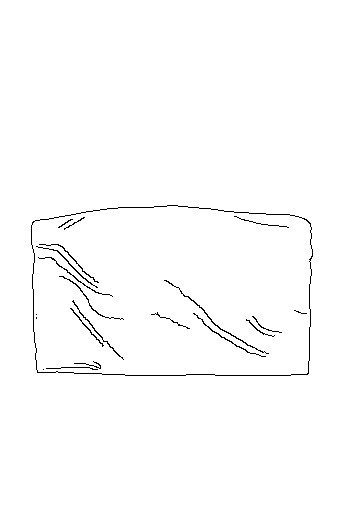

In [126]:
# Example usage
sketch_list = get_image_paths('../../dataset/karol-skorulski/karol-skorulski_edge_new', 
                              '../../dataset/ghoumrassi/ghoumrassi_edge_new')

sketch_path = np.random.choice(sketch_list)
sketch = Image.open(sketch_path).convert('L')
sketch

In [137]:
caption = "a black leather clutch bag"

caption: a black leather clutch bag


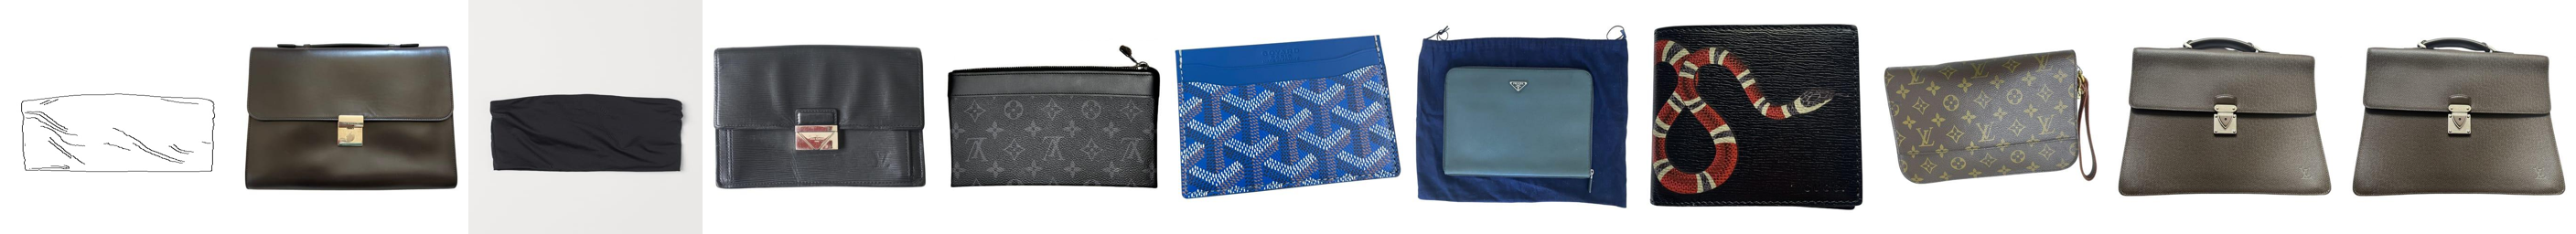

In [138]:
query_feat = get_feature(model, sketch, caption, preprocess_val)
im_list = [sketch] + get_image_list(query_feat, nbrs, all_image_paths)
result_image = get_concat_hn(im_list)

print('caption: '+ caption)
display(result_image) 

# Demo

In [ ]:
# %pip install gradio==4.42.0

In [140]:
import sys
import torch
import json
from pathlib import Path
import io
import base64
import numpy as np
from PIL import Image, ImageDraw
from torch.utils.data import Dataset, DataLoader
from sklearn.neighbors import NearestNeighbors
import gradio as gr

sys.path.append('../code/')
from clip.model import CLIP
from clip.clip import _transform, tokenize

# Load Model
gpus = [0, 1, 2, 3, 4]
torch.cuda.set_device(gpus[0])

model_config_file = "../code/training/model_configs/ViT-B-16.json"
model_file = "../ckpt/taskformer_model.pth"

with open(model_config_file, 'r') as f:
    model_info = json.load(f)
        
model = CLIP(**model_info)

loc = f"cuda:{gpus[0]}"
checkpoint = torch.load(model_file, map_location=loc)

if next(iter(checkpoint.items()))[0].startswith('module'):
    checkpoint = {k[len('module.'):]: v for k, v in checkpoint.items()}
    
model.load_state_dict(checkpoint, strict=False)
model = torch.nn.DataParallel(model, device_ids=gpus)
model = model.cuda().eval()

# Data Preprocessing
def preprocess_images(image_list, transform):
    dataset = SimpleImageFolder(image_list, transform=transform)
    dataloader = DataLoader(
        dataset,
        batch_size=32,
        shuffle=False,
        num_workers=1,
        pin_memory=True,
        drop_last=False,
    )
    return dataloader

class SimpleImageFolder(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        with Image.open(image_path) as img:
            if self.transform is not None:
                img = self.transform(img)
            return img, image_path

    def __len__(self):
        return len(self.image_paths)

def get_image_paths(*dirs):
    image_list = []
    for path in dirs:
        for item in Path(path).glob('*'):
            if '.ipynb' not in str(item):
                image_list.append(str(item))
    return image_list

preprocess_val = _transform(model.module.visual.input_resolution, is_train=False)
image_list = get_image_paths('../../dataset/karol-skorulski/karol-skorulski_image', 
                                '../../dataset/ghoumrassi/ghoumrassi_image',
                                '../../dataset/Abrumu')
dataloader = preprocess_images(image_list, preprocess_val)

def extract_features(model, dataloader):
    all_image_features, all_image_paths = [], []
    with torch.no_grad():
        for images, image_paths in dataloader:
            images = images.cuda(non_blocking=True)
            image_features = model.module.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            all_image_features.append(image_features.cpu().numpy())
            all_image_paths.extend(image_paths)
    return np.vstack(all_image_features), all_image_paths

all_image_features, all_image_paths = extract_features(model, dataloader)

def get_feature(model, sketch, text, transformer):
    img_tensor = transformer(sketch).unsqueeze(0).cuda()
    txt_tensor = tokenize([str(text)]).cuda()
    with torch.no_grad():
        sketch_feature = model.module.encode_sketch(img_tensor)
        text_feature = model.module.encode_text(txt_tensor)
        sketch_feature /= sketch_feature.norm(dim=-1, keepdim=True)
        text_feature /= text_feature.norm(dim=-1, keepdim=True)
    return model.module.feature_fuse(sketch_feature, text_feature)

nbrs = NearestNeighbors(n_neighbors=6, algorithm='brute', metric='cosine').fit(all_image_features)

def mark_boundary(img, color=(0, 255, 0)):
    draw = ImageDraw.Draw(img)
    draw.rectangle([5, 5, img.width - 5, img.height - 5], outline=color, width=10)
    return img

def get_image_list(query_feat, nbrs, all_image_paths):
    distances, indices = nbrs.kneighbors(query_feat.cpu().numpy())
    im_list = []
    for ind in indices[0]:
        file_loc = all_image_paths[ind]
        with Image.open(file_loc) as img:
            img = img.convert("RGB")
            im_list.append(img)
    return im_list

def get_concat_grid(ims, rows):
    cols = (len(ims) + rows - 1) // rows  # Calculate the number of columns
    width, height = ims[0].size
    grid = Image.new('RGB', size=(cols * width, rows * height))
    
    for i, im in enumerate(ims):
        grid.paste(im.resize((width, height)), box=(i % cols * width, i // cols * height))
    return grid

# Gradio Interface Function
def generate_results(sketch, caption):
    try:
        # Access the composite image data
        if isinstance(sketch, dict) and 'composite' in sketch:
            composite_image_data = sketch['composite']
            
            # Convert the composite image data from a numpy array to a PIL image
            sketch_image = Image.fromarray(composite_image_data)
        else:
            raise ValueError("Sketch dictionary does not contain the expected 'composite' key.")
        
        # Generate the feature from the sketch and caption
        query_feat = get_feature(model, sketch_image, caption, preprocess_val)
        print("Generated query feature")
        
        # Retrieve similar images
        im_list = get_image_list(query_feat, nbrs, all_image_paths)
        print(f"Retrieved {len(im_list) - 1} similar images")

        # Concatenate images horizontally
        result_image = get_concat_grid(im_list, rows=2)
        print("Concatenated images")

        return result_image

    except Exception as e:
        print(f"Error occurred: {e}")
        return None  # Return None or an appropriate error message/image


# Gradio Interface Setup
sketch_input = gr.Sketchpad(label="Draw your sketch here")
caption_input = gr.Textbox(lines=2, placeholder="Enter caption here...", label="Caption")

gr.Interface(fn=generate_results, 
             inputs=[sketch_input, caption_input], 
              outputs=gr.Image(type="pil"),
             title="Sketch & Caption-based Image Retrieval",
             description="Draw a sketch and provide a caption to retrieve similar images from the dataset."
            ).launch(share=True)

Is not instance - Visual Transformer
Running on local URL:  http://127.0.0.1:7862
Running on public URL: https://1a96e48711695222d9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Generated query feature
Retrieved 5 similar images
Concatenated images
Generated query feature
Retrieved 5 similar images
Concatenated images
Generated query feature
Retrieved 5 similar images
Concatenated images
